In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# TO load dataset
class MNISTDataset(Dataset):
    def __init__(self, csv_path):
        data = pd.read_csv(csv_path)
        self.labels = data.iloc[:, 0].values
        self.images = data.iloc[:, 1:].values / 255.0
        self.images = self.images.reshape(-1, 1, 28, 28).astype('float32')

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [24]:
# simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(), # 28 x 28 --> 784
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)
    

In [25]:
# simple cnn model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # 28x28 → 28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 → 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 14x14 → 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14x14 → 7x7
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                # 32 * 7 * 7 = 1568
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)           # 10 output classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [26]:
# training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(loader), correct / total

In [27]:
# validation function 
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            mages, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
    return total_loss / len(loader), correct / total

In [28]:
# training loop ,plottings
def main(csv_path, model_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = MNISTDataset(csv_path)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

    if model_type == "nn":
        model = SimpleNN().to(device)
    else:
        model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(10):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    
    # Plot loss and accuracy
    epochs = range(1, 11)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1: Train Loss=0.4469, Acc=0.8713 | Val Loss=0.2143, Acc=0.9361
Epoch 2: Train Loss=0.1835, Acc=0.9461 | Val Loss=0.1802, Acc=0.9433
Epoch 3: Train Loss=0.1330, Acc=0.9608 | Val Loss=0.1310, Acc=0.9602
Epoch 4: Train Loss=0.1004, Acc=0.9696 | Val Loss=0.1110, Acc=0.9662
Epoch 5: Train Loss=0.0806, Acc=0.9755 | Val Loss=0.1027, Acc=0.9682
Epoch 6: Train Loss=0.0656, Acc=0.9797 | Val Loss=0.1038, Acc=0.9686
Epoch 7: Train Loss=0.0542, Acc=0.9831 | Val Loss=0.0978, Acc=0.9702
Epoch 8: Train Loss=0.0421, Acc=0.9868 | Val Loss=0.0990, Acc=0.9710
Epoch 9: Train Loss=0.0350, Acc=0.9891 | Val Loss=0.0942, Acc=0.9732
Epoch 10: Train Loss=0.0317, Acc=0.9896 | Val Loss=0.0982, Acc=0.9720


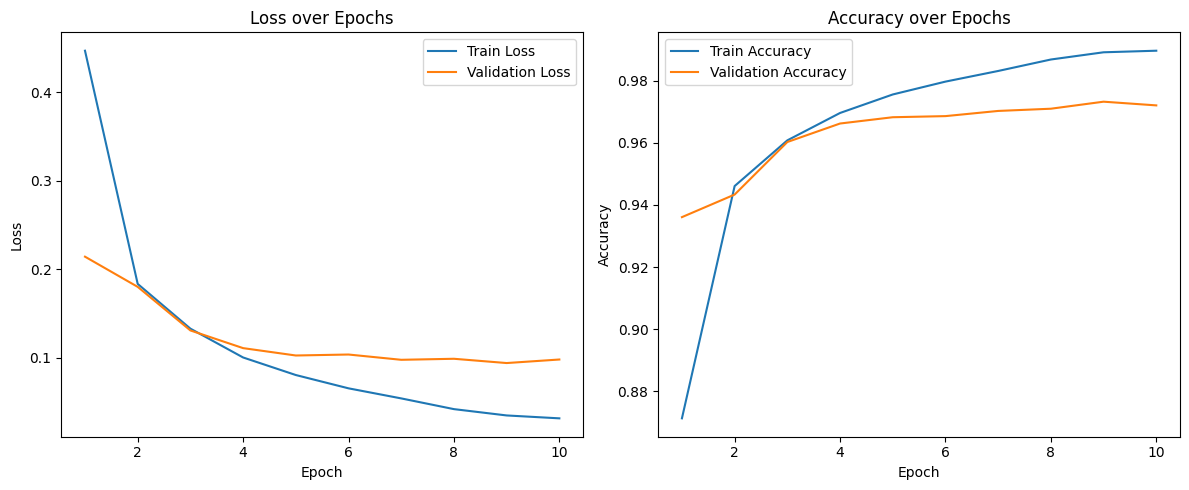

In [29]:
main(csv_path="dataset.csv", model_type="nn")

Epoch 1: Train Loss=0.3265, Acc=0.8999 | Val Loss=0.1186, Acc=0.9643
Epoch 2: Train Loss=0.0859, Acc=0.9727 | Val Loss=0.0668, Acc=0.9795
Epoch 3: Train Loss=0.0558, Acc=0.9825 | Val Loss=0.0725, Acc=0.9737
Epoch 4: Train Loss=0.0437, Acc=0.9869 | Val Loss=0.0532, Acc=0.9838
Epoch 5: Train Loss=0.0349, Acc=0.9891 | Val Loss=0.0526, Acc=0.9833
Epoch 6: Train Loss=0.0288, Acc=0.9910 | Val Loss=0.0470, Acc=0.9851
Epoch 7: Train Loss=0.0235, Acc=0.9924 | Val Loss=0.0507, Acc=0.9829
Epoch 8: Train Loss=0.0197, Acc=0.9935 | Val Loss=0.0456, Acc=0.9861
Epoch 9: Train Loss=0.0132, Acc=0.9959 | Val Loss=0.0533, Acc=0.9854
Epoch 10: Train Loss=0.0133, Acc=0.9959 | Val Loss=0.0448, Acc=0.9875


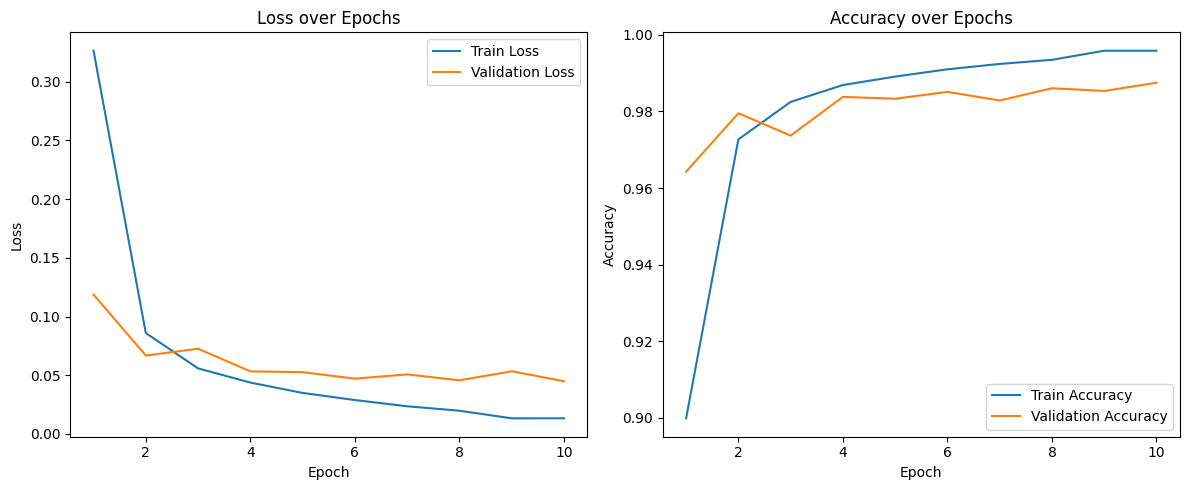

In [30]:
main(csv_path="dataset.csv", model_type="cnn")